<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Constants" data-toc-modified-id="Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Constants</a></span></li><li><span><a href="#Map-example" data-toc-modified-id="Map-example-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Map example</a></span></li><li><span><a href="#Localisation-code" data-toc-modified-id="Localisation-code-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Localisation code</a></span><ul class="toc-item"><li><span><a href="#Class-and-functions-definition" data-toc-modified-id="Class-and-functions-definition-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Class and functions definition</a></span><ul class="toc-item"><li><span><a href="#Base-class-(Moving_point)" data-toc-modified-id="Base-class-(Moving_point)-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Base class (Moving_point)</a></span></li><li><span><a href="#Particle-filter" data-toc-modified-id="Particle-filter-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Particle filter</a></span></li><li><span><a href="#Pose-of-the-robot" data-toc-modified-id="Pose-of-the-robot-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Pose of the robot</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import pandas as pd # used to read the csv
import csv          # used to read the csv
import matplotlib.pyplot as plt
import math
import numpy as np
import random

plt.rcParams["figure.figsize"] = (13,9) # To change plot size

# Constants

In [2]:
DEBUG = False
VERBOSE_PARTICLE = False # to print infos messages

# Map things
MAP_REAL = [841*2,1189] # [mm] (x,y dimensions of the map, here 2*A0)


# The same for any robot
THYMIO_WHEELBASE = 95 # [mm]
THYMIO_SHAPE =  [[ 55.0, -30.0, -30.0,  55.0,  80.0,  55.0],
                 [-47.5, -47.5,  47.5,  47.5,   0.0, -47.5]]
                # [mm] Shape of the thymio robot, for plots
PROX_POS = [[72,72], [13,-13]] # [mm] (x,y coords of the prox sensors)
WEIGHT_RESAMPLE_THRSH = 0.001
ISLOST_THRSH = 10 # [mm] max standard deviation allowed

# To tune for a robot
SPEED_L_STD = 7 # [thymio units]
SPEED_R_STD = 9 # [thymio units]
SPEED_CONVERSION_FACTOR = 61.1/147.732 # [from thymio units to mm/ms]
PROX_L_STD = 10 # [thymio units]
PROX_R_STD = 10 # [thymio units]
FEATURE2PROX_L = {'grass' : 320,
                  'road' : 1020,
                  'crossing' : 945}
FEATURE2PROX_R = {'grass' : 226,
                  'road' : 1020,
                  'crossing' : 700}

# Map example
given by Nathan

In [3]:
file_CSV = open('output/roads.csv')
reader = csv.reader(file_CSV)
roads = list(reader)

file_CSV = open('output/passage.csv')
reader = csv.reader(file_CSV)
passage = list(reader)

myMap = {'road': roads,
         'crossing': passage}

# Localisation code
## Class and functions definition
The maths for the odometry from the wheels speeds is taken from the book "Elements of Robotics" by Mordechai Ben-Ari and Francesco Mondada.
###  Base class (Moving_point)
This class is used to define only once the fuctions for the evolution of a 2 wheeled robot.

In [4]:
class Moving_point:
    '''
    One moving point having the same dynamics as the robot.
    The robot origin is considered in between the wheel (center of rotation) (Where the hole is).
    
    Public variables:
    -x: [float] horizontal coordinate of the point. (mm)
    -y: [float] vertical coordinate of the point. (mm)
    -theta: [float] orientation of the point (theta == 0 <=> looks at +x). (rad)
    '''
    def __init__(self, *args, **kwargs):
        # -- Public --
        self.set_coords(*args)
        return     
        
       
    def __repr__(self):
        r = "Current position:\n"
        r += f"x = \t\t{round(self.x,2)}\n" 
        r += f"y = \t\t{round(self.y,2)}\n"
        r += f"theta = \t{round(self.theta,2)}\n"
        return r
    
    
    def get_coords(self):
        '''
        Get the coords as a dict {'x':x, 'y':y, 'theta':theta}.
        
        Arguments:
        - void
        
        Outputs:
        - dict of floats {'x':x, 'y':y, 'theta':theta}
        '''
        return {'x':self.x, 'y':self.y, 'theta':self.theta}
    
    
    def set_coords(self, *args, **kwargs):
        '''
        Set the coordinates.
        
        Arguments:
        - dict of floats {'x':x, 'y':y, 'theta':theta} OR 3 floats x, y, theta
        
        Outputs:
        - void
        '''
        if len(args) == 3:
            self.x = args[0]
            self.y = args[1]
            self.theta = args[2]
        elif len(args) == 1 and type(*args) == dict:
            self.x = args[0]['x']
            self.y = args[0]['y']
            self.theta = args[0]['theta'] 
        else:
            print("Error: Coordiantes must be set either with a dict or with x, y and theta.")
        return
      
    
    def prox_is_out_of_map(self):
        '''
        Check if the Thymio ground sensors are out of the map.
        Returns True if the prox are out of the map.
        '''
        # Extract the coords of the ground sensors (POI)
        pts = range(len(PROX_POS[0]))
        #    rotate the shape
        POI_x = [PROX_POS[0][i]*math.cos(self.theta) - PROX_POS[1][i]*math.sin(self.theta) for i in pts]
        POI_y = [PROX_POS[0][i]*math.sin(self.theta) + PROX_POS[1][i]*math.cos(self.theta) for i in pts]
        #    shift the shape
        POI_x = [POI_x[i] + self.x for i in pts]
        POI_y = [POI_y[i] + self.y for i in pts]
        
        # Check if the points are in the map bounds
        isOut = False
        for i in pts:
            isOut = isOut or POI_x[i] >= MAP_REAL[0]
            isOut = isOut or POI_y[i] >= MAP_REAL[1]
            isOut = isOut or POI_x[i] < 0
            isOut = isOut or POI_y[i] < 0
        
        return isOut
    
    
    def _mm2map(point, map_shape):
        '''
        Converts the point from mm to map coordinates.
        map_shape = [max_x, max_y]
        '''
        return [int(point[i]/MAP_REAL[i]*map_shape[i]) for i in range(len(point))]


    def _expected_prox(self, theMap):
        '''
        Computes the expected prox values for a point (in mm) on the map.

        Arguments:
        - dict of floats {'x':x, 'y':y, 'theta':theta} OR 3 floats x, y, theta
        '''    
        # Extract the points of interest (POI)
        pts = range(len(PROX_POS[0]))
        #    rotate the shape
        POI_x = [PROX_POS[0][i]*math.cos(self.theta) - PROX_POS[1][i]*math.sin(self.theta) for i in pts]
        POI_y = [PROX_POS[0][i]*math.sin(self.theta) + PROX_POS[1][i]*math.cos(self.theta) for i in pts]
        #    shift the shape
        POI_x = [POI_x[i] + self.x for i in pts]
        POI_y = [POI_y[i] + self.y for i in pts]

        # Determine what kind of feature is at the POI
        theMap_max = [len(theMap['road']), len(theMap['road'][0])]
        POI_map = [Moving_point._mm2map([POI_x[i], POI_y[i]], theMap_max) for i in pts]
        feature = ['grass', 'grass']
        for i in pts:
            idx_x = POI_map[i][0]
            idx_y = POI_map[i][1]
            if self.prox_is_out_of_map():
                idx_x %= theMap_max[0]
                idx_y %= theMap_max[1]

            if theMap['road'][idx_x][idx_y] == 1:
                feature[i] = 'road'
            elif theMap['crossing'][idx_x][idx_y] == 1:
                feature[i] = 'crossing'
            else:
                feature[i] = 'grass'

        # Associate the feature to a prox value
        expected_prox = [FEATURE2PROX_L[feature[0]], FEATURE2PROX_R[feature[1]]]
        
        return expected_prox
    
    
    def _speed2mmps(self, speed):
        '''
        Convert Thymio speed into mm/s.
        
        Arguments:
        - speed: list of both wheelspeeds [speed_L, speed_R], in Thymio units
        
        Output:
        - speed: list of both wheelspeeds [speed_L, speed_R], in mm/s
        '''
        mySpeed = np.array(speed)
        return mySpeed*SPEED_CONVERSION_FACTOR
    
    
    def _apriori_odometry(self, speed, dt):
        speed_odo = self._speed2mmps(speed)
        dl = speed_odo[0]*dt
        dr = speed_odo[1]*dt
        
        dtheta = (dr-dl)/THYMIO_WHEELBASE
        dc = (dl+dr)/2
        
        self.x += dc*math.cos(self.theta + dtheta/2)
        self.y += dc*math.sin(self.theta + dtheta/2)
        self.theta += dtheta
        self.theta %= 2*math.pi
        return

### Particle filter
The particle class should not be used/accessed outside of this module.
A small library exists [here](https://filterpy.readthedocs.io/en/latest/monte_carlo/resampling.html). A tutorial is [here](https://salzis.wordpress.com/2015/05/25/particle-filters-with-python/). Also, [this YouTube video](https://www.youtube.com/watch?v=aUkBa1zMKv4&ab_channel=AndreasSvensson) explains the principle of the filter.

Pseudocode :
```python
def PARTICLE_FILTERING(e, N, dbn):
    '''
    Short: returns a set of samples for the next time step
    
    inputs: 
    - e, the new incoming evidence
    - N, the number of samples to be maintained
    - dbn, a Dynamic Bayesian Network with prior P(X0), transition model P(X1 | X0), sensor model P(E1 | X1)

    persistent:
    - S, a vector of samples of size N, initially generated from P(X0)

    local variables: 
    - W, a vector of weights of size N
    '''
    for i in range(N):
        # step 1: Transition for each particle
        S[i] = sample from P(X1 | X0 = S[i])

        # step 2: Assign weight to particles given the measurement
        W[i] = P(e | X1 = S[i])

        # step 3: Resample the particles
        S = WEIGHTED-SAMPLE-WITH-REPLACEMENT(N, S, W)
    return S
```

In [5]:
class Particle(Moving_point):
    '''
    One particle representing the robot. The robot origin is considered in between the wheel (center of rotation) (Where the hole is).
    
    Public variables:
    -x: [float] horizontal coordinate of the robot. (mm)
    -y: [float] vertical coordinate of the robot. (mm)
    -theta: [float] orientation of the robot (theta == 0 <=> looks at +x). (rad)
    '''
    _w_max = 0
    
    def __init__(self, *args, **kwargs):
        # -- Public --
        super().__init__(*args)
            
        self.w = 1 # weight of the particle
        
    
    def reset_total_weight():
        '''
        Resets the total weight.
        '''
        Particle._w_sum = 0
        Particle._w_max = 0
    
    
    def get_weight(self):
        '''
        Get the weight.
        
        Arguments:
        - void
        
        Outputs:
        - weight (float)
        '''
        return self.w
    
    
    def set_weight(self, weight):
        '''
        Set the weight.
        
        Arguments:
        - weight (float)
        
        Outputs:
        - void
        '''
        self.w = weight
        return
    
    
    def transition(self, speed, dt):
        '''
        Updates the particle from the measured motor speeds.
        
        Arguments:
        - speed: list of both wheelspeeds [speed_L, speed_R]
        - dt: float, time interval between each update, in ms
        
        Output:
        -void
        '''
        if VERBOSE_PARTICLE:
            print("Particle pose is getting updated ...")
        
        # Checking correcti dimensions of the args
        try:
            speed_not_ok = len(speed) != 2
        except:
            speed_not_ok = True
        if speed_not_ok:
            print("'speed' argument is of incorrect type/size.")
            print("\tspeed: list of both wheelspeeds [speed_L, speed_R]")
            return
        if type(dt) != int and type(dt) != float:
            print("'dt' argument is of incorrect type/size.")
            print("\tdt: float, time interval between each update, in ms")
            return
        
        # Add gaussian noise to the speeds
        speed_noized = [0, 0]
        speed_noized[0] = speed[0] + random.gauss(0, SPEED_L_STD)
        speed_noized[1] = speed[1] + random.gauss(0, SPEED_R_STD)
        
        # Do the transition
        self._apriori_odometry(speed_noized, dt)

        
        # Print infos for debugging
        if VERBOSE_PARTICLE:
            print(f"The speeds are : {self._speed2mmps(speed_noized)}")
            print(f"The particle is at : {self}")
            print("Particle pose has been updated successfully !\n")
        return
    
    
    def weight(self, prox, myMap):
        '''
        Updates the particle's weight from the measured ground value.
        The weight computed here is not normalised.
        The weight is the likelyhood of the measured prox w.r.t. the expected prox.

        Arguments:
        - prox: list of both ground proximity sensors (delta) [prox_L, prox_R]
        - dt: float, time interval between each update, in ms

        Output:
        -void
        '''
        # Compute weight (assume the prox noise is gaussian)
        mp = np.array(prox) # measured prox
        ep = np.array(self._expected_prox(myMap)) # expected prox
        dp = mp-ep
        self.w = math.exp(-(dp[0]**2/PROX_L_STD + dp[1]**2/PROX_R_STD)/2)        
        
        # Update weight sum
        Particle._w_sum += self.w
        
        # Update max weight
        if self.w > Particle._w_max:
            Particle._w_max = self.w
        return
    
    
    def plot(self, plot_theta=True):
        SCALING_THETAS_PLOT = 1

        # Creating end point to plot theta
        theta_dx = SCALING_THETAS_PLOT*math.cos(self.theta)
        theta_dy = SCALING_THETAS_PLOT*math.sin(self.theta)

        # Plotting the circle
        if Particle._w_max > 1e-15: # to avoid division by zero  
            plt.scatter(self.x, self.y, marker='.', s=300*(self.w/Particle._w_max), alpha=0.3)
        else:
            plt.scatter(self.x, self.y, marker='.', s=300*(0.1), alpha=0.3)

        # Plotting theta arrow
        if plot_theta:
            plt.arrow(self.x, self.y, theta_dx, theta_dy, width=0.1, head_width=1, alpha=0.2)

        return

### Pose of the robot
The pose of the robot is the interface for the global code.

In [6]:
class Pose(Moving_point):
    '''
    Class for the pose of the robot. The robot origin is considered in between the wheel (center of rotation) (Where the hole is).
    
    Public variables:
    -x: [float] Most probable horizontal coordinate of the robot. (mm)
    -y: [float] Most probable vertical coordinate of the robot. (mm)
    -theta: [float] Most probable orientation of the robot (theta == 0 <=> looks at +x). (rad)
    -isLost: [bool] If the localisation gets too imprecise, isLost == True
    '''
    def __init__(self, x, y, theta, isLost=False, nb_particles=100):
        # -- Public --
        super().__init__(x, y, theta)
        self.isLost = isLost
        
        # Initialisation of the particle filter
        self._particles = []
        self._weights = []
        self._out = []

        for i in range(nb_particles):
            myParticle = Particle(self.get_coords())
            self._particles.append(myParticle.get_coords())
            self._weights.append(myParticle.get_weight())
            self._out.append(myParticle.prox_is_out_of_map())
        
     
    def update(self, speed, prox, dt, myMap):
        '''
        Updates the pose from the displacement and sensors values.
        
        Arguments:
        - speed: list of both wheelspeeds [speed_L, speed_R]
        - prox: list of both ground.delta [prox_1, prox_2]
        - dt: float, time interval between each update, in seconds
        - myMap: dict of array containing the map informations {'road': ..., 'passage': ...}
        
        Output:
        -void
        '''
        if DEBUG:
            print("Pose is getting updated ...")
        
        # Checking correcti dimensions of the args
        try:
            speed_not_ok = len(speed) != 2
            prox_not_ok = len(prox) != 2
        except:
            speed_not_ok = True
            prox_not_ok = True
        if speed_not_ok:
            print("'speed' argument is of incorrect type/size.")
            print("\tspeed: list of both wheelspeeds [speed_L, speed_R]")
            return
        if prox_not_ok:
            print("'prox' argument is of incorrect type/size.")
            print("\tprox: list of both ground.delta [prox_1, prox_2]")
            return
        if type(dt) != int and type(dt) != float:
            print("'dt' argument is of incorrect type/size.")
            print("\tdt: float, time interval between each update, in ms")
            return
        
        # Update particles
        self._update_particles(speed, prox, dt, myMap)
        
        if max(self._weights) > 0:
            # Update position from the particles (weighted average of the particle)
            xs = [self._particles[i]['x'] for i in range(len(self._particles))]
            xs = np.array(xs)
            ys = [self._particles[i]['y'] for i in range(len(self._particles))]
            ys = np.array(ys)
            thetas = [self._particles[i]['theta'] for i in range(len(self._particles))]
            thetas = np.array(thetas)

            new_x = np.sum(xs*np.array(self._weights)) / sum(self._weights)
            new_y = np.sum(ys*np.array(self._weights)) / sum(self._weights)
            
            self.theta = math.atan2((new_y-self.y), (new_x-self.x))
            if self.theta < 0:
                self.theta += 2*math.pi
            self.x = new_x
            self.y = new_y

            # Check if lost
            distance_to_particles = [math.sqrt(xs[i]**2 + ys[i]**2) for i in range(len(self._particles))]
            if np.std(distance_to_particles) >= ISLOST_THRSH:
                self.isLost = True
                if DEBUG:
                    print('Lost because of particle spread')
            else:
                self.isLost = False
        else:
            # Do update using coord, because particles didn't work
            self._apriori_odometry(speed, dt)
            self.isLost = True
            if DEBUG:
                print('Lost because w = 0.')
        
        # Print warning if any particle or pose sensors is out of map
        anything_out = sum(self._out)+self.prox_is_out_of_map()
        if anything_out and self.prox_is_out_of_map():
            print(f"Warning : Pose and {anything_out-1} particles have their ground sensor out of the map.")
            print(f"\tContinuing as if the map was a torus.")
        if anything_out and not self.prox_is_out_of_map():
            print(f"Warning : {anything_out} particles have their ground sensor out of the map.")
            print(f"\tContinuing as if the map was a torus.")
        
        # Print infos for debugging
        if DEBUG:
            print(f"The speeds are : {self._speed2mmps(speed)}")
            print(f"The prox are : {prox}")
            print(self)
            print("Pose has been updated.\n\n")
        return
    
    
    def plot(self, plot_theta=True, theta_size=1, plot_particles=True):
        '''
        Plots the current pose and the particles.
        '''
        # Plotting the particles
        if plot_particles:
            for i in range(len(self._particles)):
                myParticle = Particle(self._particles[i])
                myParticle.set_weight(self._weights[i])
                myParticle.plot(plot_theta=plot_theta)
        
        # Creating end points to plot thetas
        theta_dx = theta_size*math.cos(self.theta)
        theta_dy = theta_size*math.sin(self.theta)

        # Plotting the pose of the thymio
        pts = range(len(THYMIO_SHAPE[0]))
        #    rotate the shape
        thy_x = [THYMIO_SHAPE[0][i]*math.cos(self.theta) - THYMIO_SHAPE[1][i]*math.sin(self.theta) for i in pts]
        thy_y = [THYMIO_SHAPE[0][i]*math.sin(self.theta) + THYMIO_SHAPE[1][i]*math.cos(self.theta) for i in pts]
        #    shift the shape
        thy_x = [thy_x[i] + self.x for i in pts]
        thy_y = [thy_y[i] + self.y for i in pts]
        if self.isLost:
            plt.scatter(self.x, self.y, marker='o', color='red', s=100)
            plt.plot(thy_x, thy_y, color='red')
        else:
            plt.scatter(self.x, self.y, marker='o', color='green', s=100)
            plt.plot(thy_x, thy_y, color='green')
            
        # Plotting the prox locations
        pts = range(len(PROX_POS[0]))
        #    rotate the shape
        thy_x = [PROX_POS[0][i]*math.cos(self.theta) - PROX_POS[1][i]*math.sin(self.theta) for i in pts]
        thy_y = [PROX_POS[0][i]*math.sin(self.theta) + PROX_POS[1][i]*math.cos(self.theta) for i in pts]
        #    shift the shape
        thy_x = [thy_x[i] + self.x for i in pts]
        thy_y = [thy_y[i] + self.y for i in pts]
        plt.scatter(thy_x, thy_y, marker='o', color='red', s=100)

        # Plotting theta arrow
        if plot_theta:
            plt.arrow(self.x, self.y, theta_dx, theta_dy, color='orange', width=0.1*theta_size, head_width=0.5*theta_size)
        
        return
    
     
    def _update_particles(self, speed, prox, dt, myMap):
        Particle.reset_total_weight()
        for i in range(len(self._particles)):
            myParticle = Particle(self._particles[i])
    
            # Transition
            myParticle.transition(speed, dt)
            self._particles[i] = myParticle.get_coords()
            if VERBOSE_PARTICLE:
                print(f"Praticle {i+1} :")
                print(myParticle)
            
            # Compute raw weights
            myParticle.weight(prox, myMap)
            self._weights[i] = myParticle.get_weight()
            
            # Check if the particle's prox is out of map
            self._out[i] = myParticle.prox_is_out_of_map()

        # Resampling the particles
        # resample only when the weights are diverse
        if np.std(self._weights) >= WEIGHT_RESAMPLE_THRSH/math.sqrt(len(self._weights)):
            idxs = [i for i in range(len(self._particles))]
            idxs = random.choices(idxs, weights=self._weights, k=len(self._particles))
            self._particles = [self._particles[i] for i in idxs]
            if VERBOSE_PARTICLE:
                print(f"Weights are : {self._weights}\nSum weight is {Particle._w_sum}")
                print(f"New idxs : {idxs}")
                print('Resampling done !\n')
        
        return

	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map was a torus.
	Continuing as if the map

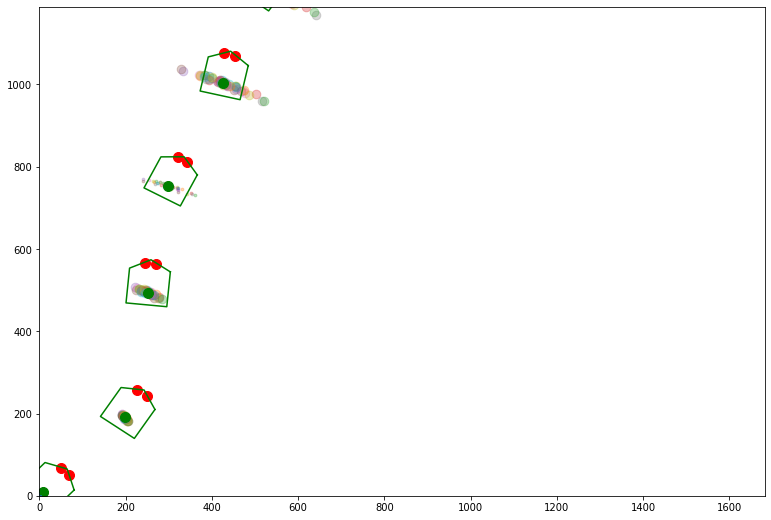

In [8]:
# testing


MAX_SPEED = 560
MIN_SPEED = 100
MAX_PROX = 1000
DT = 0.2
NB_PARTICLES = 50


myPose = Pose(0,0,math.pi/4, isLost=False, nb_particles=NB_PARTICLES)

for i in range(80):
    speed = [random.randrange(MIN_SPEED, MAX_SPEED), random.randrange(MIN_SPEED, MAX_SPEED)]
    prox = myPose._expected_prox(myMap)
    
    # add noise on the prox
    prox[0] += random.gauss(0, PROX_L_STD)
    prox[1] += random.gauss(0, PROX_R_STD)

    myPose.update(speed, prox, DT, myMap)
    
    # plot only 1 on 10 steps
    if i%10 == 0:
        myPose.plot(plot_theta=False, theta_size=5, plot_particles=True)
    
plt.scatter(0, 0, marker='+')
plt.xlim(0, MAP_REAL[0])
plt.ylim(0, MAP_REAL[1])
plt.show()

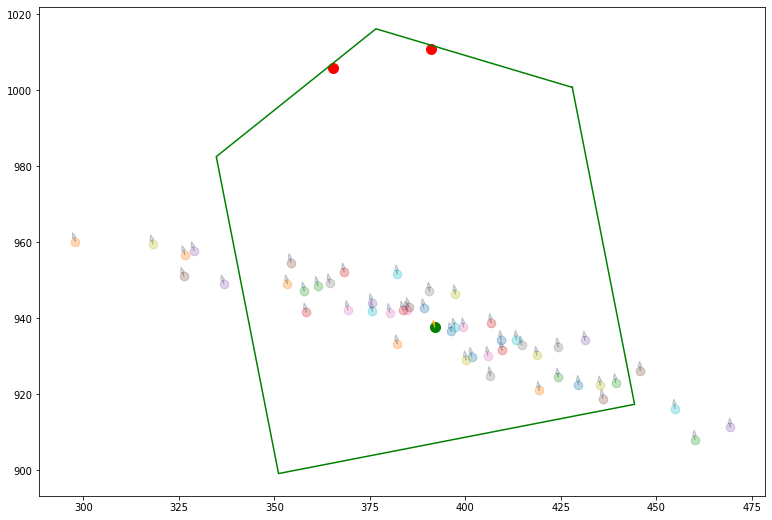

In [14]:
myPose.plot()

In [32]:
print(myMap['road'])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

